4/4 [==============================] - 0s 2ms/step
Epoch: 0, Discriminator Loss: 0.7087299227714539, Generator Loss: 0.6509860157966614, Discriminator Accuracy: 46.666666865348816%
4/4 [==============================] - 0s 2ms/step
Epoch: 100, Discriminator Loss: 0.9394683241844177, Generator Loss: 0.3841370940208435, Discriminator Accuracy: 47.14285731315613%
4/4 [==============================] - 0s 2ms/step


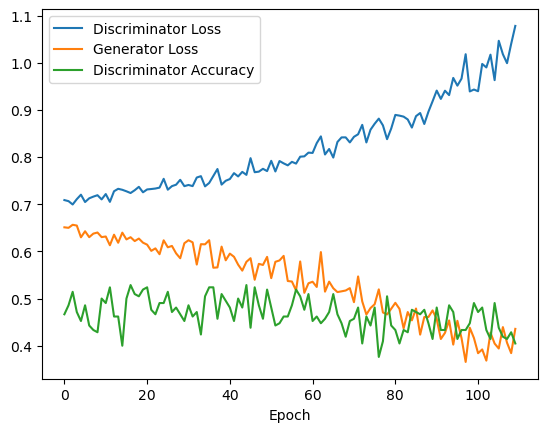

In [3]:
#Construct basic schema of Adversarial Neural Network
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define lists to store the losses and accuracies
d_losses = []
g_losses = []
d_accs = []

# Load the CSV dataset
data = pd.read_csv('input_data.csv')
x_train = data.iloc[:, 1:-1].values  # Extract all features except the first (index) and the last (label) columns
y_train = data.iloc[:, -1].values    # Extract the last (label) column

# Generator model
def create_generator(noise_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=noise_dim),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(x_train.shape[1], activation='linear'),
    ])
    return model


# Discriminator model
def create_discriminator(input_dim):
    model = Sequential([
        Dense(32, activation='relu', input_dim=input_dim),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid'),
    ])
    return model


# Combine the Generator and Discriminator to create the Adversarial Neural Network
def create_gan_network(generator, discriminator):
    noise_dim = generator.layers[0].input_shape[-1]
    input_noise = Input(shape=(noise_dim,))
    img = generator(input_noise)
    discriminator.trainable = False
    validity = discriminator(img)
    gan = Model(input_noise, validity)
    return gan


# Define hyperparameters
noise_dim = 100
epochs = 110
batch_size = 105

# Create the models
generator = create_generator(noise_dim)
discriminator = create_discriminator(x_train.shape[1])
gan = create_gan_network(generator, discriminator)

# Compile the models
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


# Train the Adversarial Neural Network
for epoch in range(epochs):
    random_noise = np.random.normal(0, 1, [batch_size, noise_dim])
    generated_data = generator.predict(random_noise)

    real_data = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

    X = np.concatenate((real_data, generated_data))
    y = np.zeros(batch_size * 2)
    y[:batch_size] = 1  # Real data

    # Train the Discriminator
    discriminator.trainable = True
    d_loss, d_acc = discriminator.train_on_batch(X, y)

    # Train the Generator by training the GAN (with fixed discriminator)
    random_noise = np.random.normal(0, 1, [batch_size, noise_dim])
    y = np.ones(batch_size)  # Fake data with label 1 (as if they were real)
    discriminator.trainable = False  # Fix the discriminator's weights before training the GAN
    g_loss = gan.train_on_batch(random_noise, y)
    
    # Append the losses and accuracies to the corresponding lists
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    d_accs.append(d_acc)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}, Discriminator Accuracy: {100 * d_acc}%")

# Plot the losses and accuracies
plt.plot(range(epochs), d_losses, label='Discriminator Loss')
plt.plot(range(epochs), g_losses, label='Generator Loss')
plt.plot(range(epochs), d_accs, label='Discriminator Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()